# Multi-Variable Time-Series : CO2 prediction  

In [1]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('../raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('../pollution.csv')


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


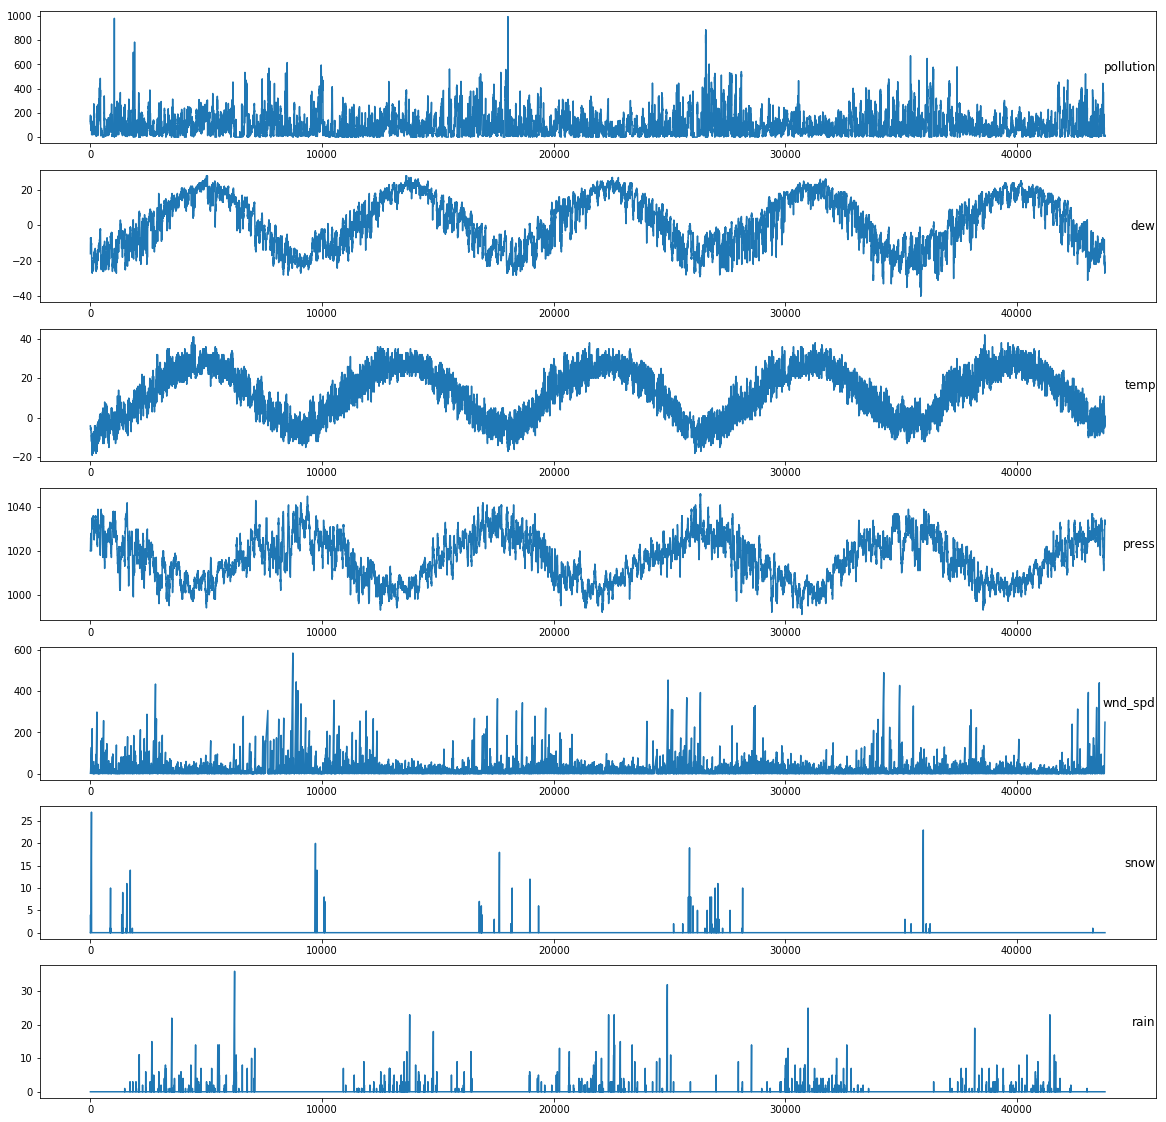

In [66]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('../pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column

#pyplot.figure()
pyplot.figure(figsize=(20,20))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1

pyplot.show()


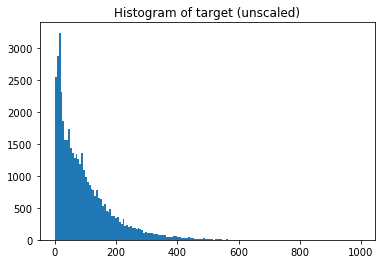

In [68]:
import matplotlib.pyplot as plt
plt.hist(values[:, 0], bins='auto') 
plt.title("Histogram of target (unscaled)")
plt.show()

In [69]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
    

In [70]:
# load dataset
dataset = read_csv('../pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 30
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)
print(reframed)

(43770, 248)
       var1(t-30)  var2(t-30)  var3(t-30)  var4(t-30)  var5(t-30)  var6(t-30)  \
30       0.129779    0.352941    0.245902    0.527273    0.666667    0.002290   
31       0.148893    0.367647    0.245902    0.527273    0.666667    0.003811   
32       0.159960    0.426471    0.229508    0.545454    0.666667    0.005332   
33       0.182093    0.485294    0.229508    0.563637    0.666667    0.008391   
34       0.138833    0.485294    0.229508    0.563637    0.666667    0.009912   
35       0.109658    0.485294    0.213115    0.563637    0.666667    0.011433   
36       0.105634    0.485294    0.213115    0.581818    0.666667    0.014492   
37       0.124748    0.485294    0.229508    0.600000    0.666667    0.017551   
38       0.120724    0.470588    0.213115    0.600000    0.666667    0.020610   
39       0.132797    0.485294    0.229508    0.618183    0.666667    0.023669   
40       0.140845    0.485294    0.229508    0.636364    0.666667    0.029018   
41       0.1529

In [53]:
print()

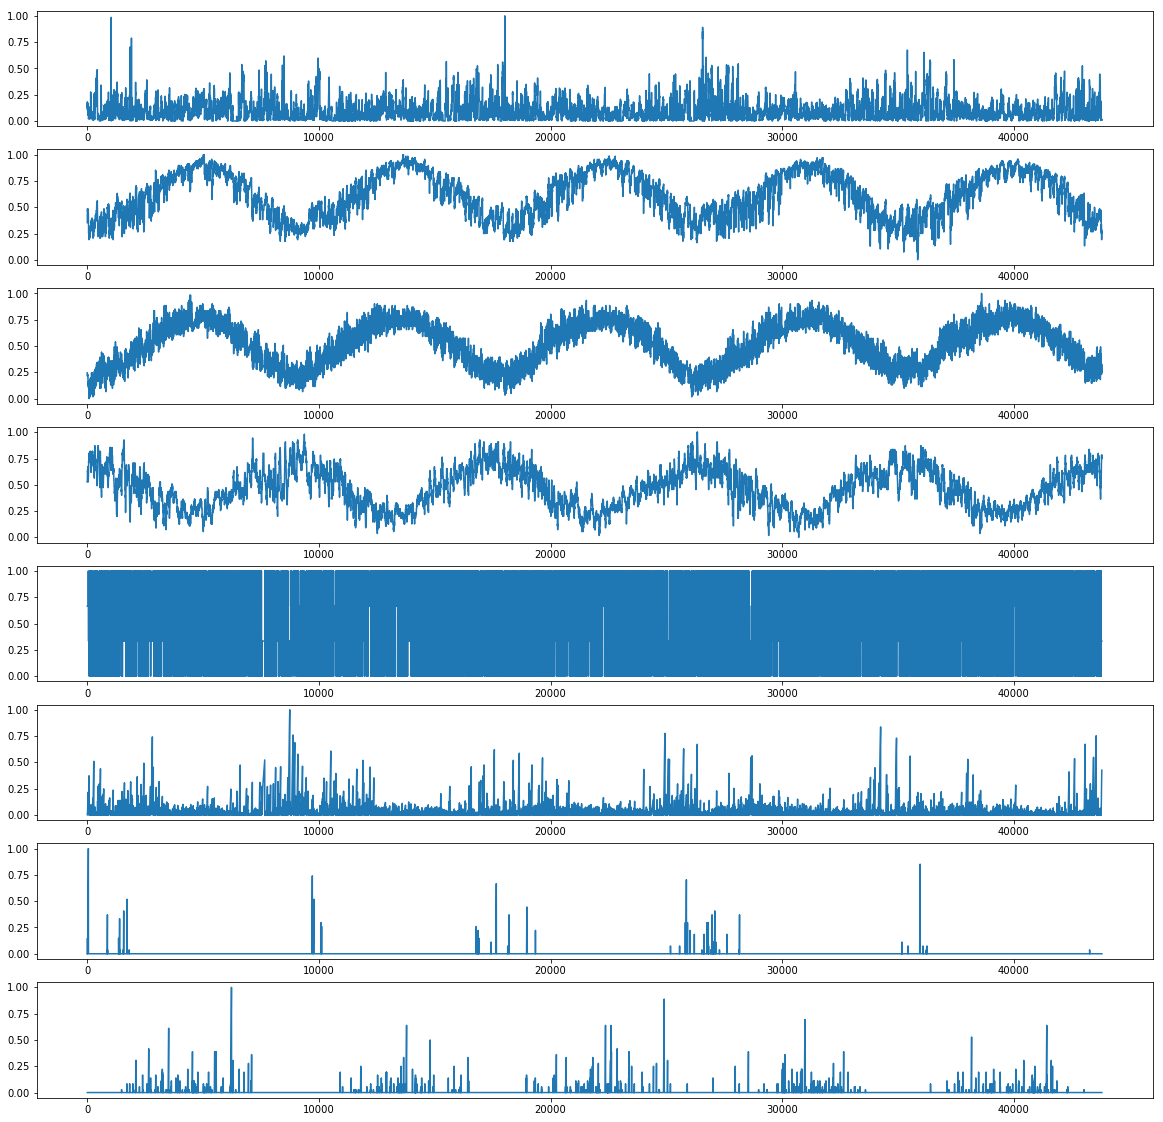

In [71]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = scaled

# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column

#pyplot.figure()
pyplot.figure(figsize=(20,20))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(scaled[:, group])
    #pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1

pyplot.show()

In [72]:
print ("shape of reframe", reframed.shape)

shape of reframe (43770, 248)


In [73]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

print("train[0] : \n",train[0])
print("train[0].shape : \n",train[0].shape)
print("train : \n",train[0, -n_features])

#################################################################
## SAVE all values of target to conver into classification then
## using histogram in java ...
#################################################################
import numpy
a = numpy.asarray(values[:, -n_features])
print("array : " , a)
numpy.savetxt("../foo.csv", a, delimiter=",") 


# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



train[0] : 
 [ 0.12977867  0.35294122  0.24590163  0.52727318  0.66666669  0.00229001
  0.          0.          0.14889336  0.36764708  0.24590163  0.52727318
  0.66666669  0.00381099  0.          0.          0.15995975  0.42647061
  0.22950819  0.54545403  0.66666669  0.00533197  0.          0.
  0.18209255  0.48529413  0.22950819  0.56363678  0.66666669  0.00839101
  0.03703704  0.          0.13883299  0.48529413  0.22950819  0.56363678
  0.66666669  0.00991199  0.07407407  0.          0.10965794  0.48529413
  0.21311474  0.56363678  0.66666669  0.01143297  0.11111111  0.          0.1056338
  0.48529413  0.21311474  0.58181763  0.66666669  0.01449201  0.14814815
  0.          0.12474848  0.48529413  0.22950819  0.60000038  0.66666669
  0.01755106  0.          0.          0.12072434  0.47058827  0.21311474
  0.60000038  0.66666669  0.0206101   0.          0.          0.13279678
  0.48529413  0.22950819  0.61818314  0.66666669  0.02366915  0.          0.
  0.14084506  0.48529413  0.229

In [74]:
print ("example 1 :\n", train_X[0])
print ("example 1 shape :\n", train_X[0].shape)
print ("expected target 1 :\n", train_y[0])


example 1 :
 [[ 0.12977867  0.35294122  0.24590163  0.52727318  0.66666669  0.00229001
   0.          0.        ]
 [ 0.14889336  0.36764708  0.24590163  0.52727318  0.66666669  0.00381099
   0.          0.        ]
 [ 0.15995975  0.42647061  0.22950819  0.54545403  0.66666669  0.00533197
   0.          0.        ]
 [ 0.18209255  0.48529413  0.22950819  0.56363678  0.66666669  0.00839101
   0.03703704  0.        ]
 [ 0.13883299  0.48529413  0.22950819  0.56363678  0.66666669  0.00991199
   0.07407407  0.        ]
 [ 0.10965794  0.48529413  0.21311474  0.56363678  0.66666669  0.01143297
   0.11111111  0.        ]
 [ 0.1056338   0.48529413  0.21311474  0.58181763  0.66666669  0.01449201
   0.14814815  0.        ]
 [ 0.12474848  0.48529413  0.22950819  0.60000038  0.66666669  0.01755106
   0.          0.        ]
 [ 0.12072434  0.47058827  0.21311474  0.60000038  0.66666669  0.0206101
   0.          0.        ]
 [ 0.13279678  0.48529413  0.22950819  0.61818314  0.66666669  0.02366915
   0.

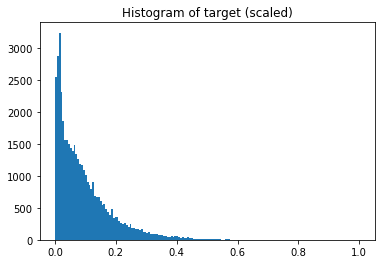

In [76]:
import matplotlib.pyplot as plt
plt.hist(values[:, -n_features], bins='auto') 
plt.title("Histogram of target (scaled)")
plt.show()


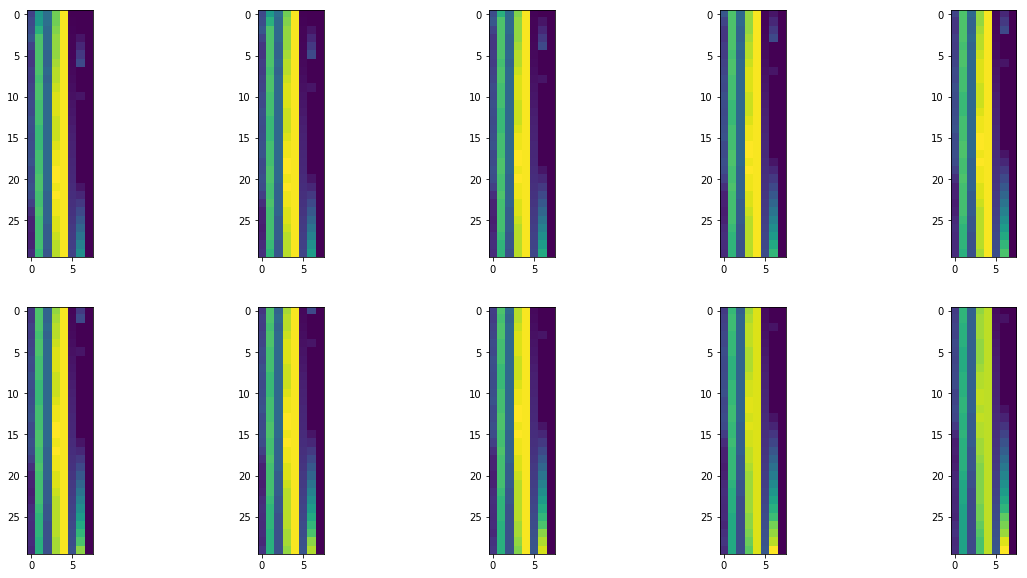

In [77]:
import matplotlib.pyplot as plt
n=10
plt.figure(figsize=(20,10))
for i in range(n):
    # display original
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(train_X[i])
    #plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
plt.show()

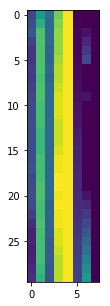

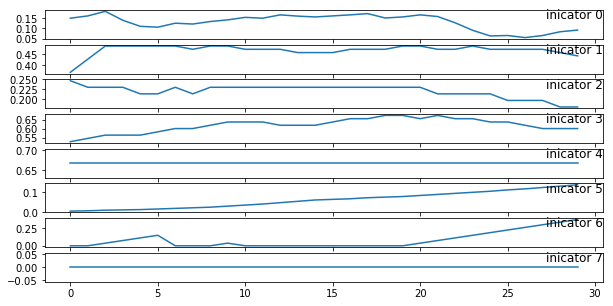

 the normalized regression value to predict for this example is :  0.0865191


In [78]:
plt.figure(figsize=(5,5))
plt.imshow(train_X[1])
#plt.gray()
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
plt.show()


from matplotlib import pyplot
groups = [0, 1, 2, 3, 4,5,6,7]
values=train_X[1]
i=1
plt.figure(figsize=(10,5))
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:,group])
	pyplot.title("inicator "+str(group), y=0.5, loc='right')
	i += 1
pyplot.show()

print (" the normalized regression value to predict for this example is : ", train_y[1])
